In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/REED.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,5.76,6.05,5.76,5.90,5.90,159600
1,1/3/2013,5.93,6.10,5.83,6.06,6.06,73600
2,1/4/2013,6.02,6.50,6.02,6.47,6.47,110700
3,1/7/2013,6.50,6.50,6.24,6.37,6.37,71900
4,1/8/2013,6.44,6.45,6.33,6.37,6.37,45200


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: -23.009999.3, cost: -35344.468750, total money: 9976.990001
epoch: 20, total rewards: -104.149998.3, cost: -35202.914062, total money: 9882.050003
epoch: 30, total rewards: -111.960000.3, cost: -35093.871094, total money: 9792.450001
epoch: 40, total rewards: -51.719994.3, cost: -35403.523438, total money: 9943.100006
epoch: 50, total rewards: -74.889994.3, cost: -35407.136719, total money: 9910.770006
epoch: 60, total rewards: -86.959996.3, cost: -35314.949219, total money: 9909.360004
epoch: 70, total rewards: -55.539995.3, cost: -35482.332031, total money: 9939.300005
epoch: 80, total rewards: -45.649993.3, cost: -35493.367188, total money: 9945.420007
epoch: 90, total rewards: -23.049996.3, cost: -35533.992188, total money: 9970.320004
epoch: 100, total rewards: -30.839995.3, cost: -35542.839844, total money: 9956.670006
epoch: 110, total rewards: -22.519994.3, cost: -35571.636719, total money: 9969.340007
epoch: 120, total rewards: -60.189994.3, cost: -35

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 5.900000, total balance 9994.100000
day 4: buy 1 unit at price 6.370000, total balance 9987.730000
day 6: buy 1 unit at price 6.160000, total balance 9981.570000
day 8: buy 1 unit at price 6.090000, total balance 9975.480000
day 9: buy 1 unit at price 5.690000, total balance 9969.790000
day 11: buy 1 unit at price 5.500000, total balance 9964.290000
day 13, sell 1 unit at price 5.260000, investment -10.847455 %, total balance 9969.550000,
day 19: buy 1 unit at price 5.730000, total balance 9963.820000
day 20, sell 1 unit at price 5.820000, investment -8.634219 %, total balance 9969.640000,
day 21, sell 1 unit at price 5.930000, investment -3.733767 %, total balance 9975.570000,
day 22, sell 1 unit at price 5.940000, investment -2.463056 %, total balance 9981.510000,
day 23: buy 1 unit at price 5.880000, total balance 9975.630000
day 26, sell 1 unit at price 5.590000, investment -1.757468 %, total balance 9981.220000,
day 27: buy 1 unit at price 5.350000, tota

day 302, sell 1 unit at price 8.000000, investment 15.942027 %, total balance 9888.919999,
day 303: buy 1 unit at price 7.740000, total balance 9881.179999
day 305: buy 1 unit at price 7.630000, total balance 9873.549999
day 306, sell 1 unit at price 7.910000, investment 21.319016 %, total balance 9881.459999,
day 307, sell 1 unit at price 7.920000, investment 18.385650 %, total balance 9889.379999,
day 310: buy 1 unit at price 5.990000, total balance 9883.389999
day 311, sell 1 unit at price 5.830000, investment -15.261630 %, total balance 9889.219999,
day 312, sell 1 unit at price 5.690000, investment -20.308121 %, total balance 9894.909999,
day 314, sell 1 unit at price 5.600000, investment -29.824563 %, total balance 9900.509999,
day 315, sell 1 unit at price 5.710000, investment -29.506176 %, total balance 9906.219999,
day 316: buy 1 unit at price 5.550000, total balance 9900.669999
day 317: buy 1 unit at price 5.520000, total balance 9895.149999
day 318: buy 1 unit at price 5.310

day 478, sell 1 unit at price 6.610000, investment 28.599228 %, total balance 9806.350000,
day 480: buy 1 unit at price 6.560000, total balance 9799.790000
day 481: buy 1 unit at price 6.510000, total balance 9793.280000
day 486, sell 1 unit at price 5.930000, investment 16.732282 %, total balance 9799.210000,
day 487, sell 1 unit at price 5.920000, investment 16.996050 %, total balance 9805.130000,
day 489, sell 1 unit at price 5.990000, investment 19.799995 %, total balance 9811.120000,
day 491: buy 1 unit at price 5.630000, total balance 9805.490000
day 492: buy 1 unit at price 5.640000, total balance 9799.850000
day 494, sell 1 unit at price 6.070000, investment 19.960479 %, total balance 9805.920000,
day 495, sell 1 unit at price 6.060000, investment 20.238095 %, total balance 9811.980000,
day 498, sell 1 unit at price 6.020000, investment 19.444445 %, total balance 9818.000000,
day 499: buy 1 unit at price 6.110000, total balance 9811.890000
day 501, sell 1 unit at price 5.940000

day 649, sell 1 unit at price 6.150000, investment 18.042227 %, total balance 9860.980000,
day 650: buy 1 unit at price 6.120000, total balance 9854.860000
day 651: buy 1 unit at price 6.280000, total balance 9848.579999
day 652, sell 1 unit at price 6.280000, investment 22.656257 %, total balance 9854.860000,
day 653: buy 1 unit at price 6.170000, total balance 9848.690000
day 656, sell 1 unit at price 5.780000, investment 13.779533 %, total balance 9854.470000,
day 658: buy 1 unit at price 5.850000, total balance 9848.620000
day 660: buy 1 unit at price 5.800000, total balance 9842.820000
day 661: buy 1 unit at price 5.510000, total balance 9837.309999
day 663, sell 1 unit at price 5.260000, investment -8.521735 %, total balance 9842.570000,
day 665, sell 1 unit at price 5.020000, investment -16.749589 %, total balance 9847.590000,
day 666: buy 1 unit at price 5.070000, total balance 9842.520000
day 667, sell 1 unit at price 5.130000, investment -13.636363 %, total balance 9847.65000

day 812, sell 1 unit at price 5.000000, investment 2.040814 %, total balance 9838.759999,
day 813, sell 1 unit at price 4.850000, investment -2.805609 %, total balance 9843.609999,
day 814: buy 1 unit at price 4.800000, total balance 9838.809999
day 815, sell 1 unit at price 4.710000, investment 2.838430 %, total balance 9843.519999,
day 817, sell 1 unit at price 4.570000, investment -0.218335 %, total balance 9848.089999,
day 818, sell 1 unit at price 4.630000, investment 0.433839 %, total balance 9852.719999,
day 821: buy 1 unit at price 4.720000, total balance 9847.999999
day 822, sell 1 unit at price 4.850000, investment -2.610444 %, total balance 9852.849999,
day 823, sell 1 unit at price 4.690000, investment -11.174245 %, total balance 9857.539999,
day 824, sell 1 unit at price 4.710000, investment -14.363636 %, total balance 9862.249999,
day 825, sell 1 unit at price 4.600000, investment -14.498145 %, total balance 9866.849999,
day 826, sell 1 unit at price 4.710000, investment 

day 989: buy 1 unit at price 4.000000, total balance 9853.450000
day 993, sell 1 unit at price 4.000000, investment 49.812730 %, total balance 9857.450000,
day 994, sell 1 unit at price 3.930000, investment 48.301884 %, total balance 9861.380000,
day 995: buy 1 unit at price 3.900000, total balance 9857.480000
day 996, sell 1 unit at price 3.950000, investment 49.621208 %, total balance 9861.430000,
day 997, sell 1 unit at price 3.950000, investment 21.538463 %, total balance 9865.380000,
day 998, sell 1 unit at price 4.100000, investment 26.543207 %, total balance 9869.480000,
day 999: buy 1 unit at price 4.100000, total balance 9865.380000
day 1000, sell 1 unit at price 4.100000, investment 13.259669 %, total balance 9869.480000,
day 1001, sell 1 unit at price 4.050000, investment 12.813378 %, total balance 9873.530000,
day 1002, sell 1 unit at price 4.150000, investment 17.563743 %, total balance 9877.680000,
day 1003, sell 1 unit at price 4.150000, investment 30.094045 %, total bal

day 1184, sell 1 unit at price 2.150000, investment -12.244896 %, total balance 9884.360002,
day 1185, sell 1 unit at price 2.250000, investment -11.764704 %, total balance 9886.610002,
day 1186, sell 1 unit at price 2.250000, investment -8.163267 %, total balance 9888.860002,
day 1187, sell 1 unit at price 2.250000, investment -11.764704 %, total balance 9891.110002,
day 1189, sell 1 unit at price 2.200000, investment 37.500001 %, total balance 9893.310002,
day 1190: buy 1 unit at price 2.100000, total balance 9891.210002
day 1192, sell 1 unit at price 2.190000, investment 36.875002 %, total balance 9893.400002,
day 1193: buy 1 unit at price 2.250000, total balance 9891.150002
day 1194: buy 1 unit at price 2.150000, total balance 9889.000002
day 1196: buy 1 unit at price 2.200000, total balance 9886.800002
day 1199: buy 1 unit at price 2.230000, total balance 9884.570002
day 1200, sell 1 unit at price 2.250000, investment 40.624998 %, total balance 9886.820002,
day 1201, sell 1 unit a

day 1342: buy 1 unit at price 2.150000, total balance 9896.890002
day 1343, sell 1 unit at price 2.150000, investment 26.470590 %, total balance 9899.040002,
day 1346: buy 1 unit at price 2.200000, total balance 9896.840002
day 1347, sell 1 unit at price 2.200000, investment 10.000002 %, total balance 9899.040002,
day 1348, sell 1 unit at price 2.450000, investment 13.953486 %, total balance 9901.490002,
day 1349, sell 1 unit at price 2.500000, investment 13.636361 %, total balance 9903.990002,
day 1351: buy 1 unit at price 2.650000, total balance 9901.340002
day 1352: buy 1 unit at price 2.900000, total balance 9898.440002
day 1353, sell 1 unit at price 2.650000, investment 20.454547 %, total balance 9901.090002,
day 1356, sell 1 unit at price 2.750000, investment 27.906971 %, total balance 9903.840002,
day 1357, sell 1 unit at price 2.750000, investment 27.906971 %, total balance 9906.590002,
day 1360, sell 1 unit at price 2.850000, investment 29.545447 %, total balance 9909.440002,


day 1630: buy 1 unit at price 3.320000, total balance 9909.470001
day 1632: buy 1 unit at price 3.650000, total balance 9905.820001
day 1634, sell 1 unit at price 3.720000, investment 0.000000 %, total balance 9909.540001,
day 1635, sell 1 unit at price 3.710000, investment 0.815217 %, total balance 9913.250001,
day 1636: buy 1 unit at price 3.570000, total balance 9909.680001
day 1637: buy 1 unit at price 3.730000, total balance 9905.950001
day 1638, sell 1 unit at price 3.600000, investment 8.433734 %, total balance 9909.550001,
day 1642, sell 1 unit at price 3.380000, investment -7.397260 %, total balance 9912.930001,
day 1644, sell 1 unit at price 3.300000, investment -7.563025 %, total balance 9916.230001,
day 1645, sell 1 unit at price 3.360000, investment -9.919574 %, total balance 9919.590001,
day 1651: buy 1 unit at price 3.470000, total balance 9916.120001
day 1652: buy 1 unit at price 3.460000, total balance 9912.660001
day 1653: buy 1 unit at price 3.290000, total balance 9

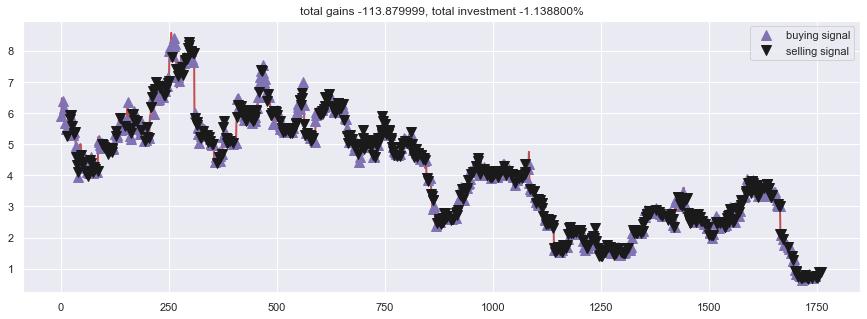

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()